In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

2023-04-30 04:03:52.131099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 04:03:52.185716: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 04:03:52.186697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 04:03:53.334321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os 

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 427.31it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


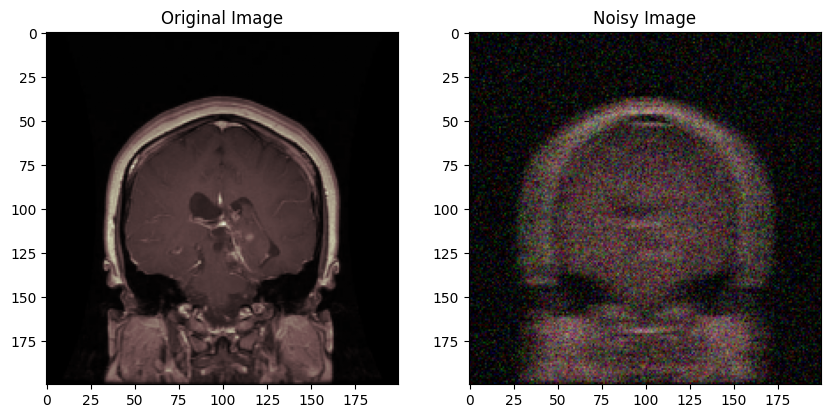

In [10]:
import numpy as np
from scipy.signal import convolve2d
from matplotlib import pyplot as plt

# Define the kernel for motion blur
kernel_size = 20
kernel = np.zeros((kernel_size, kernel_size))
kernel[int((kernel_size-1)/2),:] = np.ones(kernel_size)
kernel = kernel / kernel_size

# Add very little Gaussian noise and motion blur to the first image in the training set
x_train_noisy = x_train.copy()
for i in range(x_train_noisy[0].shape[-1]):
    x_train_noisy[0][:,:,i] = np.clip(convolve2d(x_train_noisy[0][:,:,i], kernel, mode='same') + np.random.normal(loc=0.0, scale=.1, size=x_train_noisy[0][:,:,i].shape), 0.0, 1.0)

# Show the original image and the noisy image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_train[0])
axs[0].set_title('Original Image')
axs[1].imshow(x_train_noisy[0])
axs[1].set_title('Noisy Image')
plt.show()


In [11]:
import numpy as np
from scipy.signal import convolve2d

# Define the kernel for motion blur
kernel_size = 20
kernel = np.zeros((kernel_size, kernel_size))
kernel[int((kernel_size-1)/2),:] = np.ones(kernel_size)
kernel = kernel / kernel_size

# Add very little Gaussian noise and motion blur to the training set
x_train_noisy = x_train.copy()
for i in range(x_train_noisy.shape[0]):
    for j in range(x_train_noisy[i].shape[-1]):
        x_train_noisy[i][:,:,j] = np.clip(convolve2d(x_train_noisy[i][:,:,j], kernel, mode='same') + np.random.normal(loc=0.0, scale=.1, size=x_train_noisy[i][:,:,j].shape), 0.0, 1.0)

# Add very little Gaussian noise and motion blur to the test set
x_test_noisy = x_test.copy()
for i in range(x_test_noisy.shape[0]):
    for j in range(x_test_noisy[i].shape[-1]):
        x_test_noisy[i][:,:,j] = np.clip(convolve2d(x_test_noisy[i][:,:,j], kernel, mode='same') + np.random.normal(loc=0.0, scale=.1, size=x_test_noisy[i][:,:,j].shape), 0.0, 1.0)


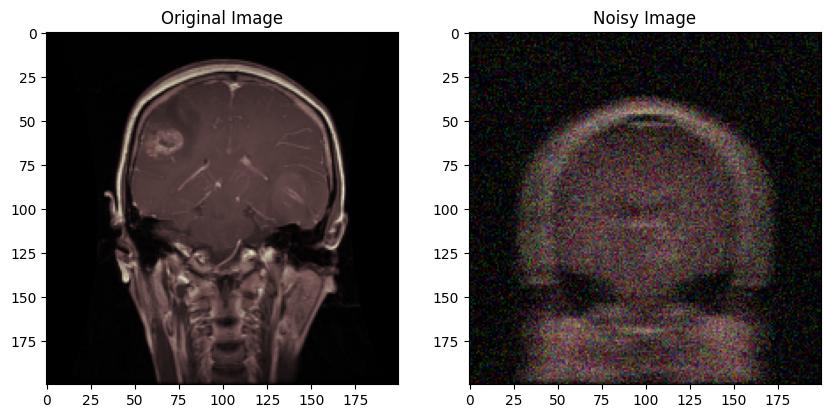

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_train[100])
axs[0].set_title('Original Image')
axs[1].imshow(x_train_noisy[0])
axs[1].set_title('Noisy Image')
plt.show()

In [13]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

# Load the saved model
model = tf.keras.models.load_model('/workspaces/Brain-Tumor-MRI-Classification/model-10-0.98-0.09.h5')

# Evaluate the model on the noisy test data
test_loss, test_acc = model.evaluate(x_test_noisy, y_test)

# Print the test accuracy
print('Test accuracy:', test_acc)

2023-04-30 04:33:44.028218: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


41/41 [==============================] - 37s 869ms/step - loss: 5.0506 - accuracy: 0.3089
Test accuracy: 0.30892449617385864


41/41 [==============================] - 37s 874ms/step


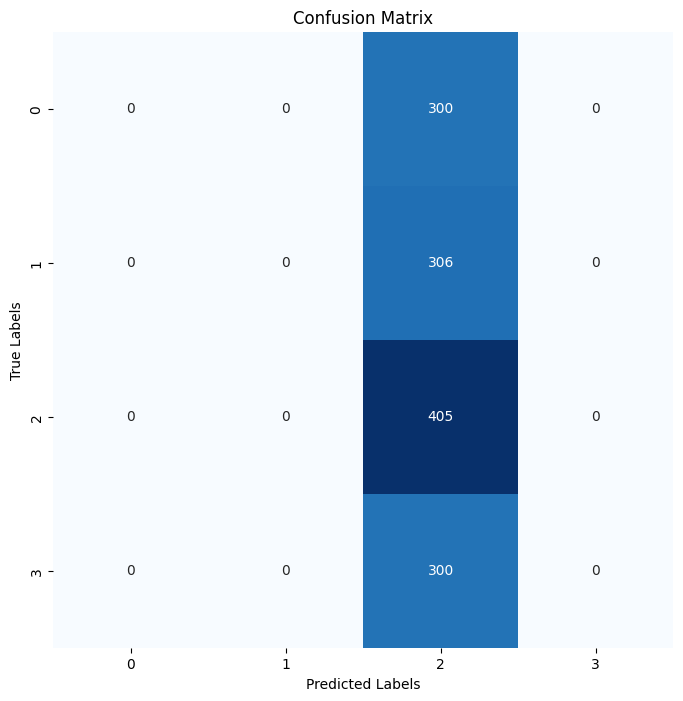

In [14]:
# Extract the predicted labels
y_pred = model.predict(x_test_noisy)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [15]:
#combine x_train and x_train_noisy and y_train and y_train
x_train = np.concatenate((x_train, x_train_noisy), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [16]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/5
286/286 [==============================] - 1406s 5s/step - loss: 0.0972 - accuracy: 0.7255 - val_loss: 0.3403 - val_accuracy: 0.2906
Epoch 2/5
286/286 [==============================] - 1367s 5s/step - loss: 0.0481 - accuracy: 0.8745 - val_loss: 0.1678 - val_accuracy: 0.6333
Epoch 3/5
286/286 [==============================] - 1348s 5s/step - loss: 0.0405 - accuracy: 0.8964 - val_loss: 0.0991 - val_accuracy: 0.7624
Epoch 4/5
286/286 [==============================] - 1347s 5s/step - loss: 0.0312 - accuracy: 0.9224 - val_loss: 0.0982 - val_accuracy: 0.7597
Epoch 5/5
286/286 [==============================] - 1327s 5s/step - loss: 0.0269 - accuracy: 0.9322 - val_loss: 0.0409 - val_accuracy: 0.8958


41/41 [==============================] - 34s 809ms/step


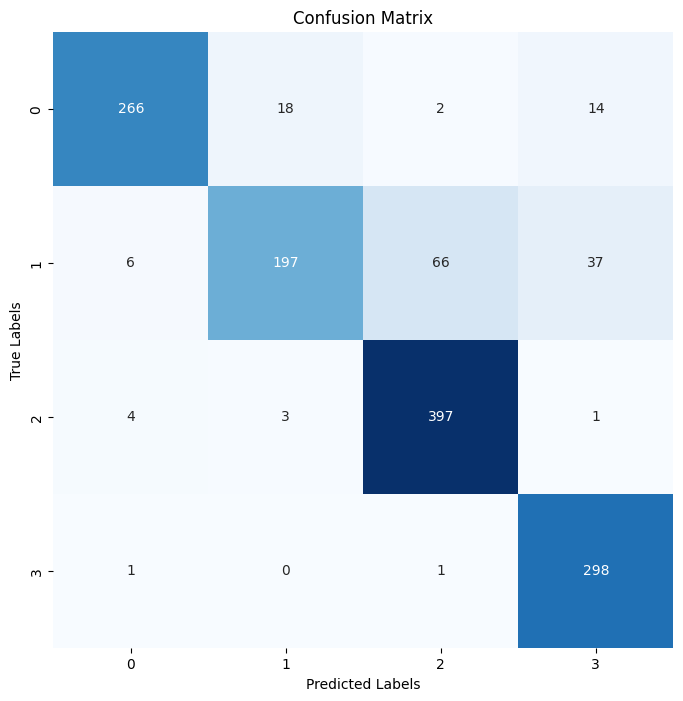

In [17]:
# Extract the predicted labels
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

41/41 [==============================] - 33s 814ms/step


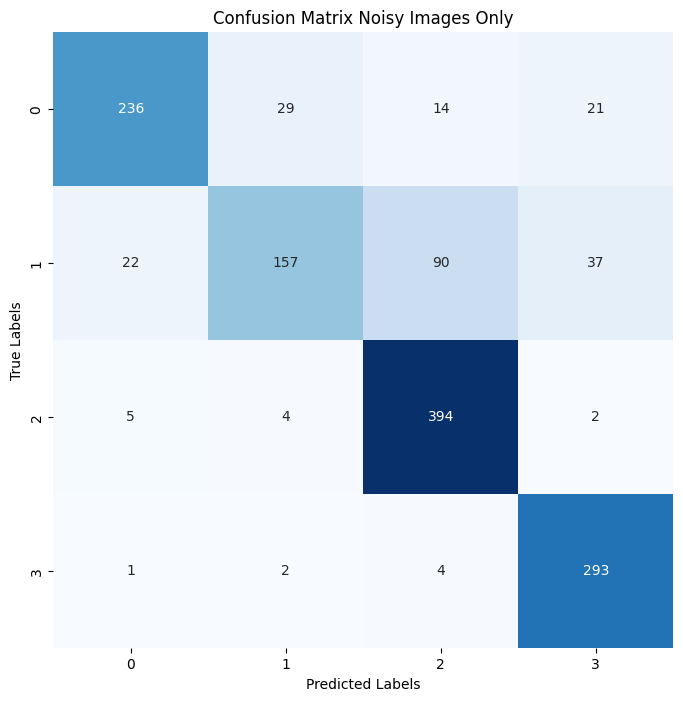

In [18]:
# Extract the predicted labels
y_pred = model.predict(x_test_noisy)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Noisy Images Only')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()